# セットアップ

In [88]:
from retry import retry
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
plt.style.use("ggplot")
plt.rcParams["font.family"] = "MS Gothic"   # 使用するフォント

In [89]:
is_download_from_suumo = False
yyyymmdd = 20230615
path_data = f"./data/data_{yyyymmdd}.pkl"
if is_download_from_suumo or not os.path.isfile(path_data):
    # 東京23区
    base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=25&pc=50&page={}"
    # base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&srch_navi=1"
    #base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&sc=13109&sc=13110&sc=13111&sc=13112&sc=13114&sc=13115&sc=13120&sc=13116&sc=13117&sc=13119&cb=0.0&ct=9999999&mb=0&mt=9999999&et=9999999&cn=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&sngz=&po1=09"


    @retry(tries=3, delay=10, backoff=2)
    def get_html(url):
        r = requests.get(url)
        soup = BeautifulSoup(r.content, "html.parser")
        return soup

    all_data = []
    max_page = 200

    for page in range(1, max_page+1):
        # define url 
        url = base_url.format(page)
        
        # get html
        soup = get_html(url)
        
        # extract all items
        items = soup.findAll("div", {"class": "cassetteitem"})
        print("page", page, "items", len(items))
        
        # process each item
        for idx_item, item in enumerate(items):
            # process for each room
            tbodys = item.find("table", {"class": "cassetteitem_other"}).findAll("tbody")
            # define variable
            data_building = {}
            # collect base information
            data_building["NAME_BUILD"] = item.find("div", {"class": "cassetteitem_content-title"}).getText().strip()
            data_building["CATEGORY"] = item.find("div", {"class": "cassetteitem_content-label"}).getText().strip()
            data_building["ADDRESS"] = item.find("li", {"class": "cassetteitem_detail-col1"}).getText().strip()
            data_building["YEAR"] = item.find("li", {"class": "cassetteitem_detail-col3"}).findAll("div")[0].getText().strip()
            data_building["STRUCTURE"] = item.find("li", {"class": "cassetteitem_detail-col3"}).findAll("div")[1].getText().strip()
            
            # process each station
            stations = item.findAll("div", {"class": "cassetteitem_detail-text"})
            for idx_station, station in enumerate(stations):
                data_building["ACCESS-" + str(idx_station)] = station.getText().strip()

            for idx_room, tbody in enumerate(tbodys):
                data_room = data_building.copy()
                data_room["ID"] = str(page) + "-" + str(idx_item) + "-" + str(idx_room)
                data_room["FLOOR"] = tbody.findAll("td")[2].getText().strip()

                data_room["RENT"] = tbody.findAll("td")[3].findAll("li")[0].getText().strip()
                data_room["MAINTENANCE_FEE"] = tbody.findAll("td")[3].findAll("li")[1].getText().strip()
                data_room["DEPOSIT"] = tbody.findAll("td")[4].findAll("li")[0].getText().strip()
                data_room["KEY_MONEY"] = tbody.findAll("td")[4].findAll("li")[1].getText().strip()

                data_room["HOUSE_LAYOUT"] = tbody.findAll("td")[5].findAll("li")[0].getText().strip()
                data_room["AREA"] = tbody.findAll("td")[5].findAll("li")[1].getText().strip()
                data_room["URL"] = "https://suumo.jp" + tbody.findAll("td")[8].find("a").get("href")
                all_data.append(data_room)

    # convert to dataframe
    df = pd.DataFrame(all_data)
else:
    df = pd.read_pickle(path_data)
    df.head(3)

# データクレンジング
列ごとにどのようなデータが入っているかを確認し，必要そうであれば整形する．

In [90]:
# NAME_BUILD
print(len(df["NAME_BUILD"].unique()))
df["NAME_BUILD"].unique()

7733


array(['小田急線 祖師ヶ谷大蔵駅 2階建 築31年', 'アイレックス', '東京メトロ千代田線 町屋駅 4階建 築16年', ...,
       'プレール・ドゥーク練馬高野台', '西武池袋線 練馬高野台駅 6階建 築12年', '広尾パークヒルズ'],
      dtype=object)

## カテゴリー
賃貸その他，賃貸テラス・タウンハウス，賃貸一戸建ては賃貸アパートにあたる場合が多そうだがサンプルも少ないので落とす

In [91]:
# 使い勝手の良い関数を作成
def show_head_urls(df, col, value):
    print(df[df[col] == value].head().get("URL").values)
show_head_urls(df, "CATEGORY", "賃貸一戸建て")

['https://suumo.jp/chintai/jnc_000075390680/?bc=100332119554'
 'https://suumo.jp/chintai/jnc_000075523091/?bc=100312299322'
 'https://suumo.jp/chintai/jnc_000082120442/?bc=100328561953'
 'https://suumo.jp/chintai/jnc_000082094416/?bc=100326334585'
 'https://suumo.jp/chintai/jnc_000082102394/?bc=100332928283']


In [92]:
# ユニークな要素を確認
print(df.groupby("CATEGORY").count().get("ID"))
category_filter_list = ["賃貸アパート", "賃貸マンション"]
df["CATEGORY_FLAG"] = df["CATEGORY"].isin(category_filter_list).values

CATEGORY
賃貸アパート           3753
賃貸テラス・タウンハウス       87
賃貸マンション         30601
賃貸一戸建て            353
Name: ID, dtype: int64


## アドレス
規格化されていそうだが，全角と半角が混ざっていたりすると嫌なので念のため置換しておく．

In [93]:
print(df["ADDRESS"].unique())

ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))

HAN2ZEN = str.maketrans(HAN, ZEN) # 半角を全角に変換するためのリスト
df["ADDRESS"] = df["ADDRESS"].str.translate(HAN2ZEN).copy()

['東京都世田谷区千歳台５' '東京都荒川区町屋２' '東京都葛飾区立石４' ... '東京都中野区野方５' '東京都杉並区今川１'
 '東京都渋谷区広尾２']


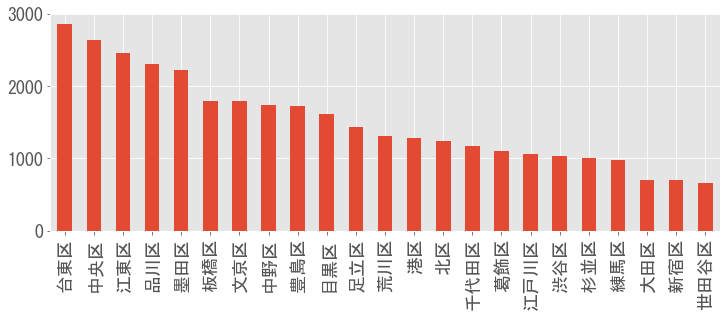

In [94]:
plt.figure(figsize = (12, 4))

df["ADDRESS_WARD"] = df["ADDRESS"].str.extract("東京都(.*)区") + "区"
df.groupby("ADDRESS_WARD").count().get("NAME_BUILD").rename("N").to_frame().sort_values("N", ascending = False).style.bar(vmin = 0)
ax = df["ADDRESS_WARD"].value_counts().plot.bar()
ax.tick_params(labelsize = 18)
# len(df["ADDRESS_WARD"].unique())

In [95]:
df["ADDRESS_DETAIL"] = df["ADDRESS"].str.extract("区(\D*)\d*$")
df["ADDRESS_NUMBER"] = df["ADDRESS"].str.extract("(\d*$)")
df["ADDRESS_WORK"] = "東京都" + df["ADDRESS_WARD"] + df["ADDRESS_DETAIL"] + df["ADDRESS_NUMBER"]
df[df["ADDRESS"] != df["ADDRESS_WORK"]]

,NAME_BUILD,CATEGORY,ADDRESS,YEAR,STRUCTURE,ACCESS-0,ACCESS-1,ACCESS-2,ID,FLOOR,...,DEPOSIT,KEY_MONEY,HOUSE_LAYOUT,AREA,URL,CATEGORY_FLAG,ADDRESS_WARD,ADDRESS_DETAIL,ADDRESS_NUMBER,ADDRESS_WORK


# 築年数
「新築」は築0年に置き換える

In [96]:
df["YEAR"].unique()
show_head_urls(df, "YEAR", "築0年")
df["YEAR_INT"] = df["YEAR"].str.replace("新築", "築0年").str.extract("築(\d*)年").astype("int")
df["YEAR_INT"].unique()

['https://suumo.jp/chintai/jnc_000083198793/?bc=100332897089'
 'https://suumo.jp/chintai/jnc_000083198792/?bc=100332897081'
 'https://suumo.jp/chintai/jnc_000083198794/?bc=100332897087'
 'https://suumo.jp/chintai/jnc_000083198798/?bc=100332782005'
 'https://suumo.jp/chintai/jnc_000083198799/?bc=100332897086']


array([31, 16, 10,  6,  0, 17,  2, 11,  7, 23, 15,  3, 35, 24, 26, 13, 29,
       19,  9, 30, 12,  5, 21, 18, 25, 14,  8, 28, 22, 46,  1, 20,  4, 48,
       54, 36, 37, 43, 34, 27, 33, 32, 42, 45, 39, 62, 44, 51, 38, 58, 47,
       40, 50, 57, 49, 41, 60, 56, 53, 55, 59, 61, 52, 64, 65])

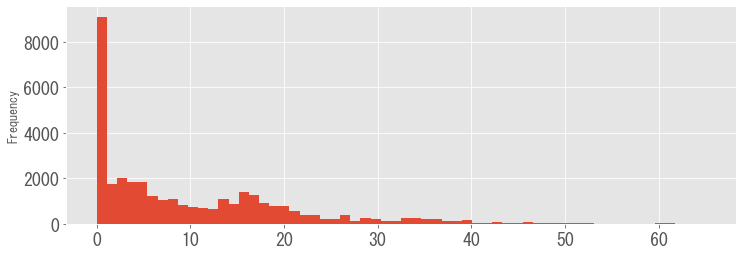

In [97]:
plt.figure(figsize = (12, 4))
df.groupby("YEAR_INT").count().get("NAME_BUILD").rename("N").to_frame().sort_values("N", ascending = False).style.bar(vmin = 0)
ax = df["YEAR_INT"].plot.hist(bins = 60)
ax.tick_params(labelsize = 18)
# len(df["ADDRESS_WARD"].unique())

# 構造
「地下`n`地上`m`階建」のような情報を`n`と`m`に分離する．`平屋`は`1階建て`に変換する

In [98]:
df["STRUCTURE_GROUND"] = df["STRUCTURE"].str.replace("平屋", "1階建").str.extract("(\d*)階建")
df["STRUCTURE_UNDERGROUND"] = df["STRUCTURE"].str.extract("地下(\d*)地上")

# 復元できるかチェック（平屋は復元できない）
'''
print(df["STRUCTURE"].unique())
 df["STRUCTURE_TEST"] = df["STRUCTURE_UNDERGROUND"].apply(lambda x : "" if pd.isna(x) else "地下" + str(x)) \
                        + df["STRUCTURE_GROUND"].mask(~(df["STRUCTURE_UNDERGROUND"].isnull()), "地上" + df["STRUCTURE_GROUND"]) + "階建"
print(df["STRUCTURE_TEST"].unique())
'''

'\nprint(df["STRUCTURE"].unique())\n df["STRUCTURE_TEST"] = df["STRUCTURE_UNDERGROUND"].apply(lambda x : "" if pd.isna(x) else "地下" + str(x))                         + df["STRUCTURE_GROUND"].mask(~(df["STRUCTURE_UNDERGROUND"].isnull()), "地上" + df["STRUCTURE_GROUND"]) + "階建"\nprint(df["STRUCTURE_TEST"].unique())\n'

# アクセス（最寄り駅）
`小田急線/祖師ヶ谷大蔵駅 歩19分`を沿線，駅，所要時間（徒歩）に分割

In [99]:
for i in range(3):
    access_i = "ACCESS-" + str(i)
    access_i_work = access_i + "_WORK"
    line_i, station_i, duration_i = "LINE-" + str(i), "STATION-" + str(i), "DURATION-" + str(i)
    df[access_i_work] = df[access_i].copy()
    df[access_i_work].mask(df[access_i_work].str.contains("バス"), "", inplace = True) # バスのみの物件は除く
    df[access_i_work].mask(df[access_i_work].str.contains("車\d*分"), "", inplace = True) # バスのみの物件は除く
    df[access_i_work].mask(df[access_i_work].str.contains("小72"), "", inplace = True) # バスのみの物件は除く
    df[line_i] = df[access_i_work].str.extract("(.*)/")
    # df["LINE-0"].unique()
    df[station_i] = df[access_i_work].str.extract("/(.*駅)")
    # df["STATION-0"].unique()
    df[duration_i] = df[access_i_work].str.extract(" 歩(.*)分").astype("float")
    # df["DURATION-0"].unique()

    # バスのみの物件を除いてうまくできている
    # df["ACCESS-0_test"] = df["LINE-0"] + "/" + df["STATION-0"] + " 歩" + df["DURATION-0"].astype("Int64").astype("str") + "分"
    # df[~((df["ACCESS-0"] == df["ACCESS-0_test"]) | (df["ACCESS-0"] == ""))].get("ACCESS-0")
df.filter(regex = "2$", axis = 1)

,ACCESS-2,LINE-2,STATION-2,DURATION-2
0,小田急線/千歳船橋駅 バス5分 (バス停)希望ヶ丘記念公園 歩3分,NaN,NaN,NaN
1,小田急線/千歳船橋駅 バス5分 (バス停)希望ヶ丘記念公園 歩3分,NaN,NaN,NaN
2,ＪＲ山手線/田端駅 歩24分,ＪＲ山手線,田端駅,24.0
3,京成本線/新三河島駅 歩13分,京成本線,新三河島駅,13.0
4,京成本線/お花茶屋駅 歩14分,京成本線,お花茶屋駅,14.0
...,...,...,...,...
34789,都営大江戸線/両国駅 歩13分,都営大江戸線,両国駅,13.0
34790,西武池袋線/石神井公園駅 歩21分,西武池袋線,石神井公園駅,21.0
34791,西武池袋線/石神井公園駅 歩21分,西武池袋線,石神井公園駅,21.0
34792,東京メトロ銀座線/渋谷駅 歩20分,東京メトロ銀座線,渋谷駅,20.0


思ったよりNaNは少ない

In [100]:
df.filter(regex = "^LINE", axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34794 entries, 0 to 34793
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LINE-0  34783 non-null  object
 1   LINE-1  33804 non-null  object
 2   LINE-2  32348 non-null  object
dtypes: object(3)
memory usage: 815.6+ KB


In [101]:
df.groupby("LINE-0").count().get("NAME_BUILD").rename("N").to_frame().sort_values("N", ascending = False).head(10).style.bar(vmin = 0)

,N
LINE-0,
ＪＲ山手線,3642
都営大江戸線,2529
東京メトロ日比谷線,2018
東京メトロ有楽町線,1795
ＪＲ総武線,1682
都営三田線,1468
東京メトロ丸ノ内線,1461
東京メトロ半蔵門線,1442
都営新宿線,1405


In [102]:
df.groupby("STATION-0").count().get("NAME_BUILD").rename("N").to_frame().sort_values("N", ascending = False).head(10).style.bar(vmin = 0)

,N
STATION-0,
錦糸町駅,624
勝どき駅,581
清澄白河駅,530
浅草駅,465
浅草橋駅,440
入谷駅,437
大塚駅,430
目黒駅,417
月島駅,413


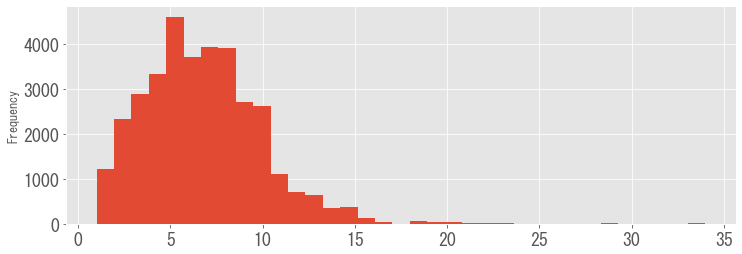

In [103]:
plt.figure(figsize = (12, 4))
ax = df["DURATION-0"].plot.hist(bins = 35)
ax.tick_params(labelsize = 18)
# len(df["ADDRESS_WARD"].unique())

# IDを建物ごとにふり直す

In [104]:
df["ID_BUILD"] = df["ID"].str.extract("(^\d*)-") + "-" + df["ID"].str.extract("-(\d*)-")
df_build = df[["ID_BUILD", "LINE-0", "STATION-0"]].drop_duplicates().reset_index(drop = True).copy()
df_build

,ID_BUILD,LINE-0,STATION-0
0,1-0,小田急線,祖師ヶ谷大蔵駅
1,1-1,東京メトロ千代田線,町屋駅
2,1-2,東京メトロ千代田線,町屋駅
3,1-3,京成押上線,京成立石駅
4,1-4,京成本線,新三河島駅
...,...,...,...
9995,200-45,東京メトロ半蔵門線,錦糸町駅
9996,200-46,ＪＲ総武線快速,錦糸町駅
9997,200-47,西武池袋線,練馬高野台駅
9998,200-48,西武池袋線,練馬高野台駅


In [105]:
df_build.groupby("LINE-0").count().get("ID_BUILD").rename("N").to_frame().sort_values("N", ascending = False).head(10).style.bar(vmin = 0)

,N
LINE-0,
ＪＲ山手線,927
東京メトロ日比谷線,505
都営大江戸線,499
ＪＲ総武線,485
都営三田線,460
東京メトロ丸ノ内線,445
東京メトロ有楽町線,422
東京メトロ千代田線,412
都営新宿線,408


In [106]:
df_build.groupby("STATION-0").count().get("ID_BUILD").rename("N").to_frame().sort_values("N", ascending = False).head(10).style.bar(vmin = 0)

,N
STATION-0,
三ノ輪駅,123
町屋駅,123
錦糸町駅,122
池袋駅,117
両国駅,111
浅草駅,110
綾瀬駅,95
北千住駅,95
都立大学駅,93


<Figure size 864x576 with 0 Axes>

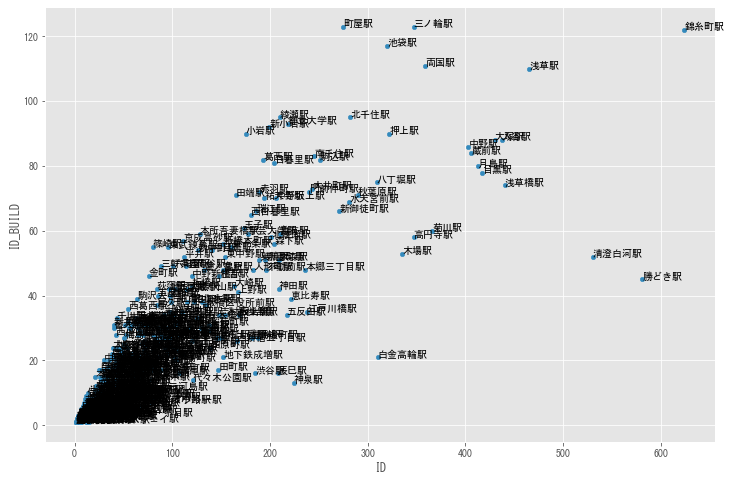

In [107]:
plt.figure(figsize = (12, 8))
df_group_station = df.groupby("STATION-0").nunique().get(["ID", "ID_BUILD"]).copy()
ax = df_group_station.plot.scatter(x = "ID", y = "ID_BUILD", figsize = (12, 8))

for i, label in enumerate(df_group_station.index):
    ax.text(df_group_station.loc[label, "ID"], df_group_station.loc[label, "ID_BUILD"], label)

# 階数

In [108]:
df["FLOOR"].unique()
show_head_urls(df, "FLOOR", "6-6階")

['https://suumo.jp/chintai/jnc_000082511309/?bc=100332880622']


In [109]:
df["FLOOR_WORK"] = df["FLOOR"].replace("-", "1階")
df["FLOOR1"] = df["FLOOR_WORK"].str.extract("(^\d*)").replace("", np.nan).astype("float")
df["FLOOR2"] = df["FLOOR_WORK"].str.extract("-(\d*)").replace("", np.nan).astype("float")
df["FLOOR3"] = - df["FLOOR_WORK"].str.extract("B(\d*)").astype("float")
df["FLOOR_MAX"] = df[["FLOOR1", "FLOOR2", "FLOOR3"]].fillna(-np.inf).max(axis = 1).astype("int")
df["FLOOR_MIN"] = df[["FLOOR1", "FLOOR2", "FLOOR3"]].fillna(np.inf).min(axis = 1).astype("int")
df["FLOOR_DOUBLE"] = (df["FLOOR_MAX"] != df["FLOOR_MIN"])
# df["FLOOR_DOUBLE"] = (~(df["FLOOR1"].isnull())) + (~(df["FLOOR2"].isnull())) + (~(df["FLOOR3"].isnull()))
df["FLOOR_MAX"].unique()

array([ 1,  7,  4,  9,  2,  3,  5, 11,  6,  8, 10, 12, 43, 44, 28, 15, 19,
       32, 17, 22, 46, 38, 53, 21, 49, 55, 39, 50, 58, 13, 14, 16, 18, 20,
       26, 29, 24, 40, 47, 25, 30, 27, 31, 37, 23, 33, 36, 42, 35, -1, -2,
       41, 34, 45, 54, 51, 52, 48])

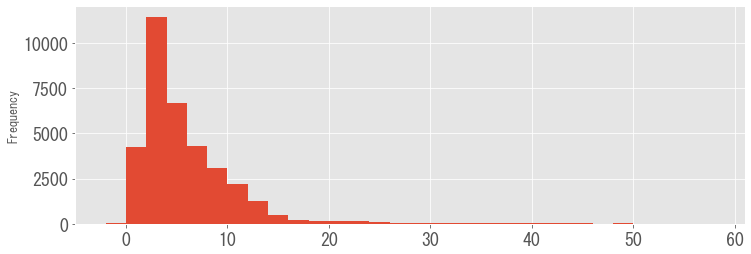

In [132]:
plt.figure(figsize = (12, 4))
ax = df["FLOOR_MAX"].plot.hist(bins = 30)
ax.tick_params(labelsize = 18)

# 家賃・管理費

In [110]:
show_head_urls(df, "RENT", "330万円")
# df["MAINTENANCE_FEE"].unique()

['https://suumo.jp/chintai/jnc_000080790625/?bc=100324723995'
 'https://suumo.jp/chintai/jnc_000080790624/?bc=100324723993']


In [111]:
df["RENT_FLOAT"] = df["RENT"].str.replace("万円", "").astype("float")
df["FLAG_RENT"] = df["RENT_FLOAT"] < 2.0 # データ入力ミスとみられる物件はフラグを立てる
df["MAINTENANCE_FEE_FLOAT"] = df["MAINTENANCE_FEE"].replace("-", 0.0).str.replace("円", "").astype("float").fillna(0.0) / 10**4.0
df["TOTAL_FEE"] = df["RENT_FLOAT"] + df["MAINTENANCE_FEE_FLOAT"]
# df.sort_values("TOTAL_FEE", ascending = False)

# 間取り

In [112]:
df["HOUSE_LAYOUT"].unique()
# show_head_urls(df, "HOUSE_LAYOUT", "ワンルーム")

array(['2LDK', '3LDK', '1LDK', '1K', '1SLDK', '1DK', '4SLDK', '2K', '2DK',
       '1SK', '4LDK', '3SLDK', '3DK', '2SLDK', '4DK', 'ワンルーム', '5K', '3K',
       '3SK', '1SDK', '2SDK', '5LDK', '8K', '7SLDK', '1LK', '5SK', '3SDK',
       '6SLDK', '5DK', '4K', '1SLK', '6LDK', '4SDK'], dtype=object)

In [113]:
df["HOUSE_LAYOUT_R"] = df["HOUSE_LAYOUT"].str.replace("ワンルーム", "1").str.extract("(^\d*)").astype("int")
df["HOUSE_LAYOUT_L"] = df["HOUSE_LAYOUT"].str.contains("L")
df["HOUSE_LAYOUT_D"] = df["HOUSE_LAYOUT"].str.contains("D")
df["HOUSE_LAYOUT_S"] = df["HOUSE_LAYOUT"].str.contains("S")
df["HOUSE_LAYOUT_K"] = df["HOUSE_LAYOUT"].str.contains("K")
# df.filter(regex = "^HOUSE_LAYOUT*", axis = 1).drop_duplicates()

In [114]:
df["AREA"].unique()
df["AREA_FLOAT"] = df["AREA"].str.replace("m2", "").astype("float")
# df.sort_values("AREA_FLOAT")

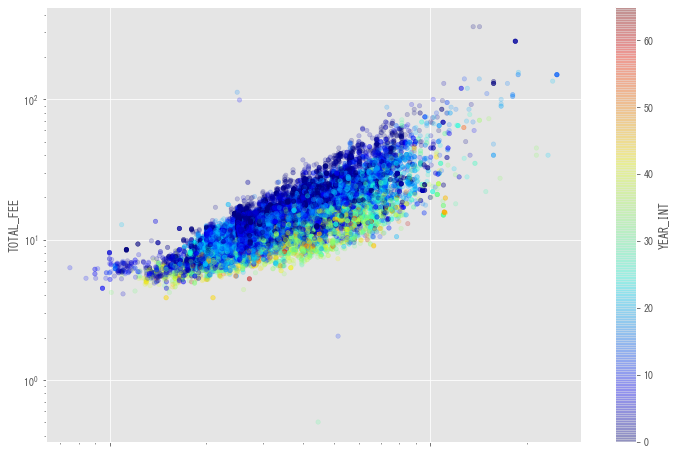

In [115]:
ax = df.plot.scatter(x = "AREA_FLOAT", y = "TOTAL_FEE", figsize = (12, 8), c = "YEAR_INT", cmap = cm.jet, alpha = 0.2)
ax.set_xscale("log")
ax.set_yscale("log")

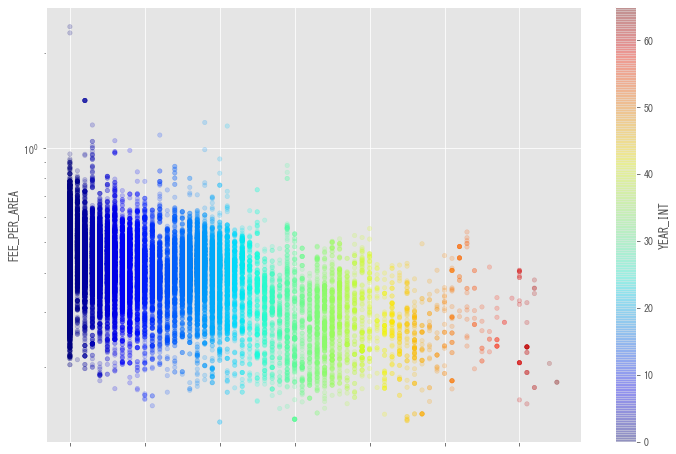

In [116]:
df["FEE_PER_AREA"] = df["TOTAL_FEE"] / df["AREA_FLOAT"]
df_univ = df[(df["FEE_PER_AREA"] > 0.05) & (df["FEE_PER_AREA"] < 3.0)].copy()
ax = df_univ.plot.scatter(x = "YEAR_INT", y = "FEE_PER_AREA", figsize = (12, 8), c = "YEAR_INT", cmap = cm.jet, alpha = 0.2)
ax.set_yscale("log")

# データ出力

In [117]:
col_drop = ["ADDRESS", "YEAR", "STRUCTURE", "ACCESS-0", "ACCESS-1", "ACCESS-2", \
    "FLOOR", "RENT", "MAINTENANCE_FEE", "DEPOSIT", "KEY_MONEY",\
    "HOUSE_LAYOUT", "AREA", "ADDRESS_WORK", "ACCESS-0_WORK", "ACCESS-1_WORK", "ACCESS-2_WORK",\
    "FLOOR_WORK", "FLOOR1", "FLOOR2", "FLOOR3", "RENT_FLOAT", "MAINTENANCE_FEE_FLOAT"]
dict_rename = {"YEAR_INT": "YEAR", "AREA_FLOAT": "AREA"}
df_output = df.drop(col_drop, axis = 1).rename(dict_rename, axis = 1).copy()
df_output.columns

Index(['NAME_BUILD', 'CATEGORY', 'ID', 'URL', 'CATEGORY_FLAG', 'ADDRESS_WARD',
       'ADDRESS_DETAIL', 'ADDRESS_NUMBER', 'YEAR', 'STRUCTURE_GROUND',
       'STRUCTURE_UNDERGROUND', 'LINE-0', 'STATION-0', 'DURATION-0', 'LINE-1',
       'STATION-1', 'DURATION-1', 'LINE-2', 'STATION-2', 'DURATION-2',
       'ID_BUILD', 'FLOOR_MAX', 'FLOOR_MIN', 'FLOOR_DOUBLE', 'FLAG_RENT',
       'TOTAL_FEE', 'HOUSE_LAYOUT_R', 'HOUSE_LAYOUT_L', 'HOUSE_LAYOUT_D',
       'HOUSE_LAYOUT_S', 'HOUSE_LAYOUT_K', 'AREA', 'FEE_PER_AREA'],
      dtype='object')

In [118]:
path_output = f"./data/data_mod_{yyyymmdd}.pkl"
df_output.to_pickle(path_output)

# モデル

徒歩時間と坪単価

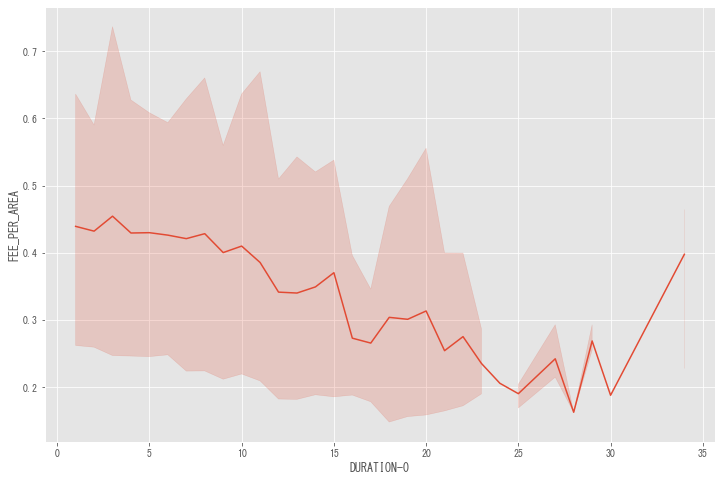

In [119]:
df_univ = df_output[~(df_output["FLAG_RENT"])].copy()
fig = plt.figure(figsize = (12, 8))
ax = sns.lineplot(x = "DURATION-0", y = "FEE_PER_AREA", data = df_univ, errorbar = "pi")

階数と坪単価

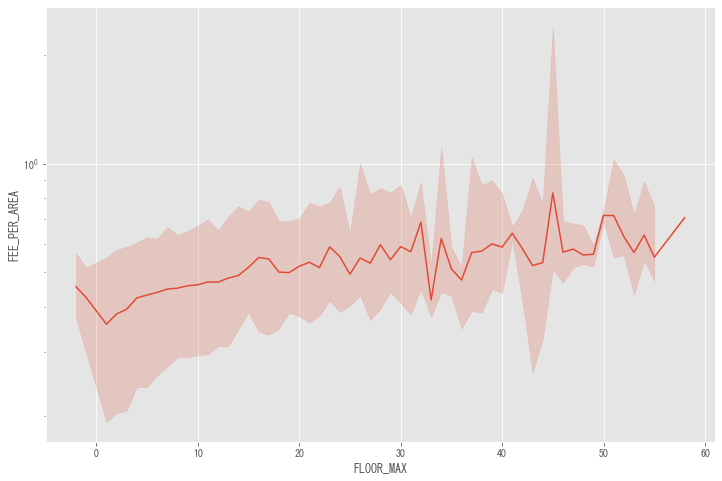

In [120]:
fig = plt.figure(figsize = (12, 8))
ax = sns.lineplot(x = "FLOOR_MAX", y = "FEE_PER_AREA", data = df_univ, errorbar = "pi")
ax.set_yscale("log")

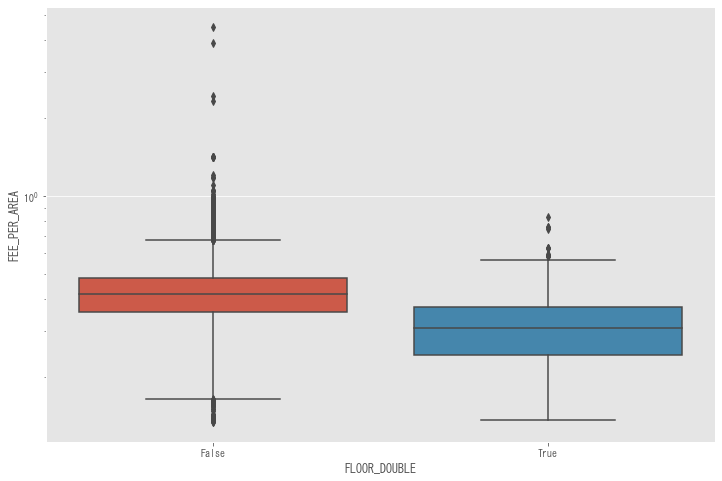

In [121]:
fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x = "FLOOR_DOUBLE", y = "FEE_PER_AREA", data = df_univ)
ax.set_yscale("log")

築年数と坪単価

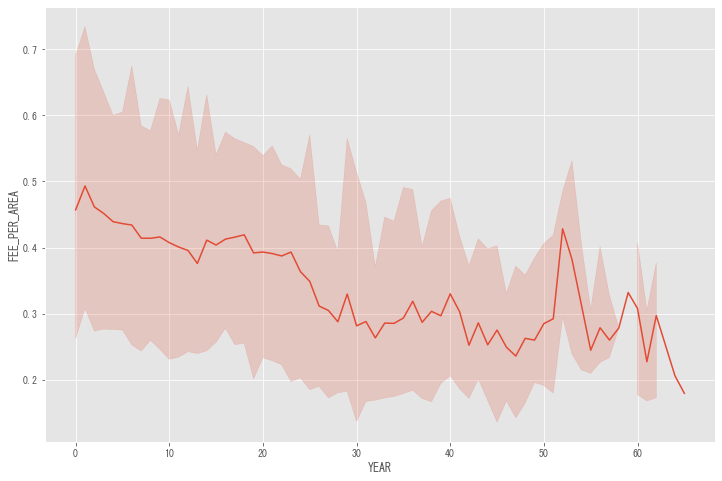

In [122]:
fig = plt.figure(figsize = (12, 8))
ax = sns.lineplot(x = "YEAR", y = "FEE_PER_AREA", data = df_univ, errorbar = "pi")
# ax.set_yscale("log")

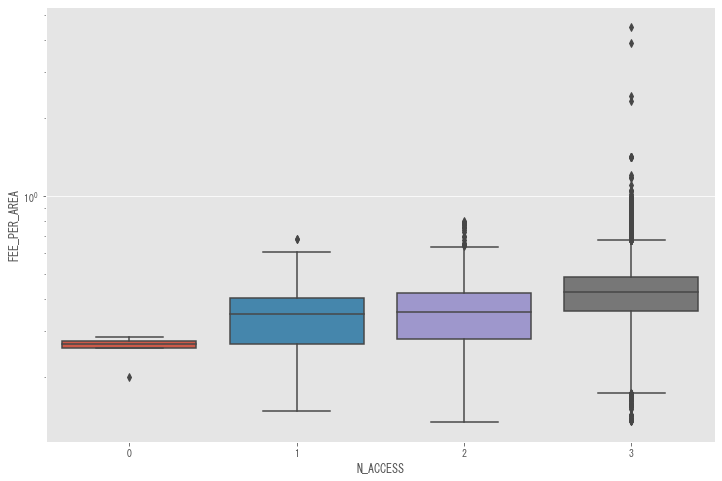

In [123]:
fig = plt.figure(figsize = (12, 8))
df_univ["N_ACCESS"] = 3 - df_univ.filter(regex = "^LINE", axis = 1).isnull().sum(axis = 1)
ax = sns.boxplot(x = "N_ACCESS", y = "FEE_PER_AREA", data = df_univ)
ax.set_yscale("log")

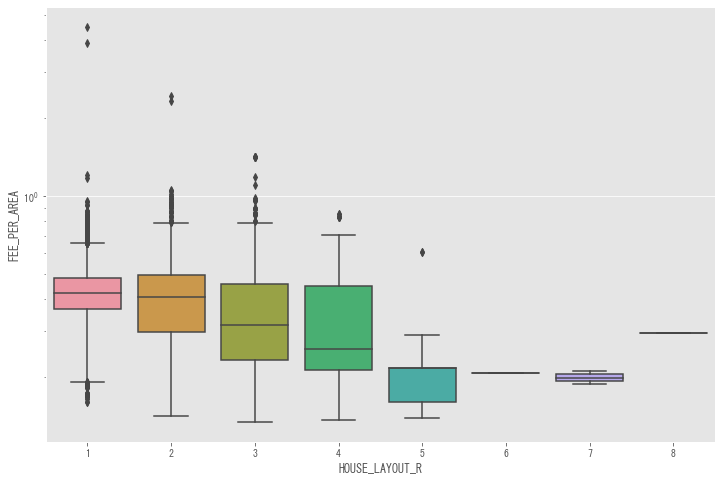

In [124]:
fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x = "HOUSE_LAYOUT_R", y = "FEE_PER_AREA", data = df_univ)
ax.set_yscale("log")

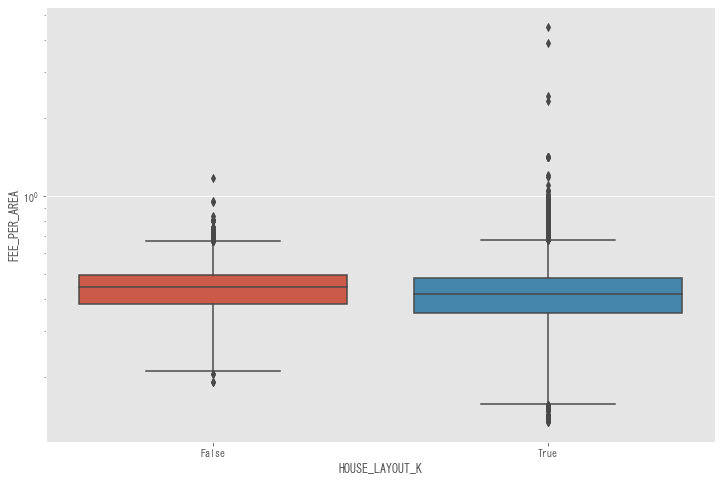

In [125]:
fig = plt.figure(figsize = (12, 8))
ax = sns.boxplot(x = "HOUSE_LAYOUT_K", y = "FEE_PER_AREA", data = df_univ)
ax.set_yscale("log")

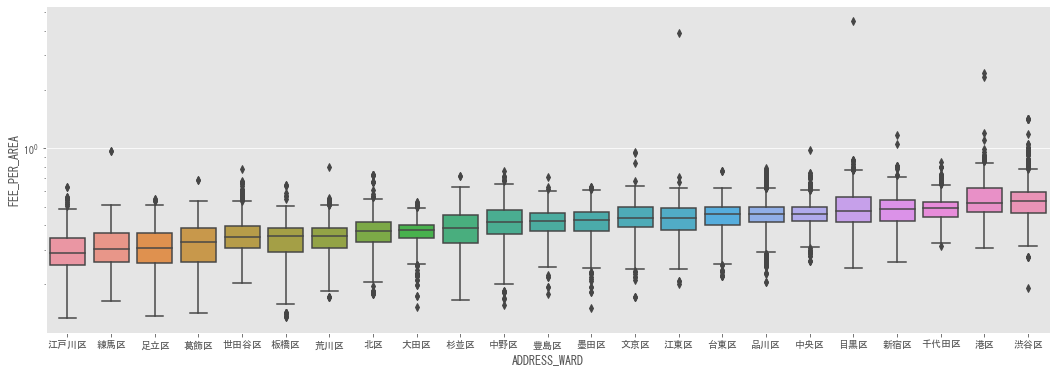

In [126]:
fig = plt.figure(figsize = (18, 6))
order_list = df_univ.groupby("ADDRESS_WARD").median().sort_values("FEE_PER_AREA").index.values
ax = sns.boxplot(x = "ADDRESS_WARD", y = "FEE_PER_AREA", data = df_univ, order = order_list)
ax.set_yscale("log")

In [127]:
df_univ.groupby("ADDRESS_DETAIL").agg({"FEE_PER_AREA": ["median", "count"]}).sort_values(("FEE_PER_AREA", "median"))

FEE_PER_AREA      
                     median count
ADDRESS_DETAIL                   
保木間                0.158504     2
興宮町                0.159526     4
南水元                0.162985     2
西一之江               0.173952     2
神明南                0.179356     3
...                     ...   ...
市谷台町               0.730731    13
松濤                 0.826236     7
鶯谷町                0.843170     2
宇田川町               0.843521    37
神宮前                1.413889     7

[721 rows x 2 columns]

In [128]:
def tile(df, col, num_cut, separate_zero = False):
    df_tile = df.copy()
    col_tile = col + "_TILE"
    if separate_zero:
        percentile_list = list(np.arange(1, num_cut - 1) / (num_cut - 1)) +  [1.0]
        quantile_list = [-np.inf, 0.0] + list(df_tile[df_tile[col] > 0].get(col).quantile(percentile_list).values)
        df_tile[col_tile] = pd.cut(df_tile[col], quantile_list, labels = False)
    else:
        df_tile[col_tile] = pd.qcut(df_tile[col], num_cut, labels = False)
    
    df_tile_agg = df_tile.groupby(col_tile).agg(["min", "median", "max"]).get(col)
    df_tile_agg.rename({"min": col_tile + "_MIN", "median": col_tile + "_MED", "max": col_tile + "MAX"}, axis = 1, inplace = True)
    df_tile = df_tile.merge(df_tile_agg, how = "left", left_on = col_tile, right_index = True).copy()
    return df_tile.filter(regex = col_tile + "*", axis = 1)

df_univ["YEAR_TILE_MED"] = tile(df_univ, "YEAR", 10, separate_zero = True).get("YEAR_TILE_MED")

In [134]:
duration_max = 15.0
df_univ["DURATION_MOD"] = df_univ["DURATION-0"].mask(df_univ["DURATION-0"] > duration_max, duration_max).copy()
floor_max = 20.0
df_univ["FLOOR_MOD"] = df_univ["FLOOR_MAX"].mask(df_univ["FLOOR_MAX"] > floor_max, floor_max).copy()

In [133]:
df_univ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34792 entries, 0 to 34793
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NAME_BUILD             34792 non-null  object 
 1   CATEGORY               34792 non-null  object 
 2   ID                     34792 non-null  object 
 3   URL                    34792 non-null  object 
 4   CATEGORY_FLAG          34792 non-null  bool   
 5   ADDRESS_WARD           34792 non-null  object 
 6   ADDRESS_DETAIL         34792 non-null  object 
 7   ADDRESS_NUMBER         34792 non-null  object 
 8   YEAR                   34792 non-null  int32  
 9   STRUCTURE_GROUND       34792 non-null  object 
 10  STRUCTURE_UNDERGROUND  3969 non-null   object 
 11  LINE-0                 34781 non-null  object 
 12  STATION-0              34781 non-null  object 
 13  DURATION-0             34781 non-null  float64
 14  LINE-1                 33802 non-null  object 
 15  ST

In [135]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

class my_linear_regression:
    def __init__(self, X, subset = [], file_name = []): # 欠損値を含む可能性がある列をsubsetで指定してdrop
        self.X = X.copy()
        self.X.dropna(subset = subset, inplace = True)
        self.col_name_list = [] # ダミー変数にした列のリストを保存する
        self.dict_dummy_list = {} # ダミー変数の要素(dropした後のもの)を列の名前ごとに保存
        self.file_name = file_name
        self.file_exist = False

    def get_dummies(self, col_name, dummy_full_list, dummy_drop): # 指定した列をダミー変数へ変更
        dummy_list = dummy_full_list[:] # dummy_full_listからremoveするとループがおかしくなる

        # Xに存在しないダミーの要素がdummy_listに入っていたら削除
        for dummy in dummy_full_list:
            if sum(self.X[col_name] == dummy) == 0: # Xがdummyを含まない場合
                dummy_list.remove(dummy)
        dummy_list.remove(dummy_drop) # 多重共線性を回避するために，指定した要素をdrop

        # ダミー変数にする
        for dummy in dummy_list:
            self.X[dummy] = (self.X[col_name].values == dummy) * 1.0

        self.col_name_list.append(col_name) # ダミー変数にした列のリストを保存
        self.dict_dummy_list[col_name] = dummy_list[:] # ダミー変数の要素(dropした後のもの)を列の名前ごとに保存

    def fit(self, target, factor_list, dummy_list = []): # ファクターを指定して回帰する，dummy_listの意味が違っていることに注意
        X_to_fit = self.X.copy()
        # 定数項を追加
        self.factor_list = factor_list[:]
        self.factor_list.insert(0, "const")
        print(self.factor_list)
        X_to_fit["const"] = np.ones(len(X_to_fit))
        
        # ダミー変数をファクターに追加
        for dummy in dummy_list:
            self.factor_list = self.factor_list + self.dict_dummy_list[dummy]

        # 回帰
        self.result = sm.OLS(X_to_fit[target], X_to_fit[self.factor_list]).fit()
        # saveで使用するので保存
        self.df_params = pd.DataFrame(index = self.result.params.index, columns = [])
        self.df_params["coef"] = self.result.params.values
        self.df_params["t"] = self.result.tvalues.values
        result_lists = ["R2", "R2_adj", "n_observations", "n_parameters", "log_likelihood", "AIC", "BIC", "mean_of_residuals"]
        self.df_result = pd.DataFrame(index = result_lists, columns = ["value"])
        self.df_result.at["R2", "value"] = self.result.rsquared
        self.df_result.at["R2_adj", "value"] = self.result.rsquared_adj
        self.df_result.at["n_observations", "value"] = self.result.nobs
        self.df_result.at["n_parameters", "value"] = len(self.factor_list)
        self.df_result.at["log_likelihood", "value"] = self.result.llf
        self.df_result.at["AIC", "value"] = self.result.aic
        self.df_result.at["BIC", "value"] = self.result.bic
        self.df_result.at["mean_of_residuals", "value"] = self.result.mse_resid

        display(self.result.summary()) # 一応回帰結果を表示する

    def save(self, sheet_name): # 回帰係数をexcelに保存
        if self.file_exist: # 今回のユニバースでファイルが存在している場合
            with pd.ExcelWriter(self.file_name + "_param.xlsx", engine = "openpyxl", mode = "a") as writer: # 上書き
                self.df_params.to_excel(writer, sheet_name = sheet_name)
            with pd.ExcelWriter(self.file_name + "_result.xlsx", engine = "openpyxl", mode = "a") as writer:
                self.df_result.to_excel(writer, sheet_name = sheet_name)
        else: # 今回のユニバースでまだファイルが存在していない場合
            self.df_params.to_excel(self.file_name + "_param.xlsx", sheet_name) # ファイルの作成
            self.df_result.to_excel(self.file_name + "_result.xlsx", sheet_name)
            self.file_exist = True # フラグの更新

    def predict(self): # fitに使用したfactor_listでtargetを推計する
        X_to_predict = self.X.copy()
        X_to_predict["const"] = np.ones(len(X_to_predict))
        
        return self.result.predict(X_to_predict[self.factor_list])

In [143]:
model = my_linear_regression(df_univ, subset = ["DURATION_MOD"])

address_ward_list = list(df_univ["ADDRESS_WARD"].unique())
house_layout_list = list(df_univ["HOUSE_LAYOUT_R"].unique())
year_tile_list = list(df_univ["YEAR_TILE_MED"].unique())

model.get_dummies("ADDRESS_WARD", address_ward_list, dummy_drop = "墨田区")
# model.get_dummies("HOUSE_LAYOUT_R", house_layout_list, dummy_drop = 1)
model.get_dummies("YEAR_TILE_MED", year_tile_list, dummy_drop = 0)

factor_list = ["DURATION_MOD", "FLOOR_MOD"]
model.fit("FEE_PER_AREA", factor_list, dummy_list = ["ADDRESS_WARD", "YEAR_TILE_MED"])

['const', 'DURATION_MOD', 'FLOOR_MOD']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FEE_PER_AREA   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     1497.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:32:15   Log-Likelihood:                 43246.
No. Observations:               34781   AIC:                        -8.642e+04
Df Residuals:                   34747   BIC:                        -8.614e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4396      0.002    231.144      0.000       0.436       0.443
DURATION_MOD    -0.0032      0.000    -25.287      0.000      -0.003      -0.003
FLOOR_MOD        0.0056   9.96e-05     56.341      0.000       0.005       0.006
世田谷区             0.0159      0.003      5.028      0.000       0.010       0.022
荒川区             -0.0398      0.002    -16.223      0.000      -0.045      -0.035
葛飾区             -0.0676      0.003    -26.026      0.000      -0.073      -0.063
足立区             -0.0868      0.002    -36.338      0.000      -0.091      -0.082
中央区              0.0480      0.002     23.161      0.000       0.044       0.052
江戸川区            -0.0786      0.003    -29.685      0.000      -0.084      -0.073
豊島区              0.0215      0.002      9.536      0.000       0.017       0.026
中野区              0.0192      0.002      8.535      0.000       0.015       0.024
板橋区             -0.0563      0.002    -25.241      0.000      -0.061      -0.052
台東区              0.0126      0.002      6.320      0.000       0.009       0.016
北区              -0.0203      0.002     -8.155      0.000      -0.025      -0.015
練馬区             -0.0691      0.003    -25.475      0.000      -0.074      -0.064
文京区              0.0473      0.002     21.119      0.000       0.043       0.052
目黒区              0.1088      0.002     47.052      0.000       0.104       0.113
品川区              0.0493      0.002     23.590      0.000       0.045       0.053
江東区              0.0174      0.002      8.478      0.000       0.013       0.021
千代田区             0.0778      0.003     30.367      0.000       0.073       0.083
杉並区             -0.0027      0.003     -1.026      0.305      -0.008       0.002
渋谷区              0.1497      0.003     56.605      0.000       0.145       0.155
大田区             -0.0118      0.003     -3.898      0.000      -0.018      -0.006
港区               0.1324      0.002     53.182      0.000       0.128       0.137
新宿区              0.0701      0.003     23.006      0.000       0.064       0.076
34              -0.1400      0.002    -90.207      0.000      -0.143      -0.137
15              -0.0714      0.002    -46.792      0.000      -0.074      -0.068
11              -0.0653      0.002    -40.532      0.000      -0.068      -0.062
5               -0.0270      0.002    -17.977      0.000      -0.030      -0.024
18              -0.0826      0.002    -53.823      0.000      -0.086      -0.080
2               -0.0020      0.001     -1.531      0.126      -0.004       0.001
8               -0.0454      0.002    -30.056      0.000      -0.048      -0.042
22              -0.1096      0.002    -69.474      0.000      -0.113      -0.107
4               -0.0220      0.002    -12.136      0.000      -0.026      -0.018
==============================================================================
Omnibus

In [175]:
df_model = model.df_params.copy()
df_model["std"] = df_model["coef"] / df_model["t"]
df_model_tile = df_model[25:].copy()
df_model_tile.loc[0, "coef"] = 0
df_model_tile.loc[0, "std"] = 0
df_model_tile.sort_index(inplace = True)
df_model_tile

,coef,t,std
0,0.000000,NaN,0.000000
2,-0.001968,-1.530836,0.001286
4,-0.021996,-12.136325,0.001812
5,-0.026977,-17.976621,0.001501
8,-0.045423,-30.055902,0.001511
11,-0.065281,-40.532462,0.001611
15,-0.071398,-46.792092,0.001526
18,-0.082551,-53.823319,0.001534
22,-0.109605,-69.473890,0.001578
34,-0.139979,-90.207091,0.001552


Text(0, 0.5, 'y')

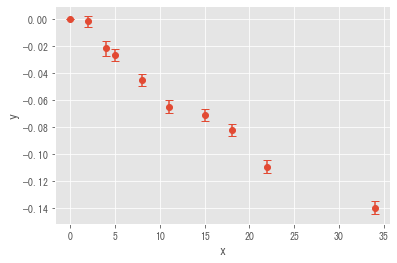

In [178]:
fig, ax = plt.subplots()
ax.errorbar(df_model_tile.index, df_model_tile["coef"], yerr = df_model_tile["std"] * 3.0, capsize=4, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y')